In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [48]:
df = pd.read_csv("clean_data.csv", index_col=False)

In [49]:
df.shape

(185950, 6)

In [50]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [51]:
def augmented_data(data):
    def get_city(address):
        return address.split(',')[1]

    def get_state(address):
        return address.split(',')[2].split(' ')[1]

    data['year'] = data['Order Date'].dt.year
    data['month'] = data['Order Date'].dt.month
    data['day'] = data['Order Date'].dt.day
    data['dayofweek'] = data['Order Date'].dt.dayofweek
    data['sales'] = data['Quantity Ordered'] * data['Price Each']

    data['cities'] = data['Purchase Address'].apply(
        lambda x: f"{get_city(x)} ({get_state(x)})")

    return data


sales_data = augmented_data(df)
sales_data.head()


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,year,month,day,dayofweek,sales,cities
0,236670,Wired Headphones,2,11.99,2019-08-31 22:21:00,"359 Spruce St, Seattle, WA 98101",2019,8,31,5,23.98,Seattle (WA)
1,236671,Bose SoundSport Headphones,1,99.99,2019-08-15 15:11:00,"492 Ridge St, Dallas, TX 75001",2019,8,15,3,99.99,Dallas (TX)
2,236672,iPhone,1,700.00,2019-08-06 14:40:00,"149 7th St, Portland, OR 97035",2019,8,6,1,700.00,Portland (OR)
3,236673,AA Batteries (4-pack),2,3.84,2019-08-29 20:59:00,"631 2nd St, Los Angeles, CA 90001",2019,8,29,3,7.68,Los Angeles (CA)
4,236674,AA Batteries (4-pack),2,3.84,2019-08-15 19:53:00,"736 14th St, New York City, NY 10001",2019,8,15,3,7.68,New York City (NY)


In [52]:
sales_data = sales_data[sales_data['year'] != 2020]
sales_data

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,year,month,day,dayofweek,sales,cities
0,236670,Wired Headphones,2,11.99,2019-08-31 22:21:00,"359 Spruce St, Seattle, WA 98101",2019,8,31,5,23.98,Seattle (WA)
1,236671,Bose SoundSport Headphones,1,99.99,2019-08-15 15:11:00,"492 Ridge St, Dallas, TX 75001",2019,8,15,3,99.99,Dallas (TX)
2,236672,iPhone,1,700.00,2019-08-06 14:40:00,"149 7th St, Portland, OR 97035",2019,8,6,1,700.00,Portland (OR)
3,236673,AA Batteries (4-pack),2,3.84,2019-08-29 20:59:00,"631 2nd St, Los Angeles, CA 90001",2019,8,29,3,7.68,Los Angeles (CA)
4,236674,AA Batteries (4-pack),2,3.84,2019-08-15 19:53:00,"736 14th St, New York City, NY 10001",2019,8,15,3,7.68,New York City (NY)
...,...,...,...,...,...,...,...,...,...,...,...,...
185945,319666,Lightning Charging Cable,1,14.95,2019-12-11 20:58:00,"14 Madison St, San Francisco, CA 94016",2019,12,11,2,14.95,San Francisco (CA)
185946,319667,AA Batteries (4-pack),2,3.84,2019-12-01 12:01:00,"549 Willow St, Los Angeles, CA 90001",2019,12,1,6,7.68,Los Angeles (CA)
185947,319668,Vareebadd Phone,1,400.00,2019-12-09 06:43:00,"273 Wilson St, Seattle, WA 98101",2019,12,9,0,400.00,Seattle (WA)
185948,319669,Wired Headphones,1,11.99,2019-12-03 10:39:00,"778 River St, Dallas, TX 75001",2019,12,3,1,11.99,Dallas (TX)


In [53]:
# group all the same products purchased on the same date together
grouped_data = sales_data.groupby(['month', 'day', 'Product'])['Quantity Ordered'].sum().reset_index()

grouped_data


,month,day,Product,Quantity Ordered
0,1,1,20in Monitor,4
1,1,1,27in 4K Gaming Monitor,7
2,1,1,27in FHD Monitor,8
3,1,1,34in Ultrawide Monitor,18
4,1,1,AA Batteries (4-pack),33
...,...,...,...,...
6807,12,31,ThinkPad Laptop,26
6808,12,31,USB-C Charging Cable,103
6809,12,31,Vareebadd Phone,10
6810,12,31,Wired Headphones,90


In [54]:
# Count repeating order and group them together

product_id = {}
id = 1

for item in grouped_data['Product']:
    if item not in product_id:
        product_id[item] = id
        id += 1

grouped_data['product_id'] = grouped_data['Product'].map(product_id)


In [55]:
# how to manage product data and train it

X = grouped_data[['product_id', 'month', 'day']]
y = grouped_data['Quantity Ordered']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

In [57]:
params={
    "learning_rate":    [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth":        [3, 4, 5, 6, 7, 8, 10, 12, 15, 18, 20, 25],
    "min_child_weight": [1, 3, 5, 7],
    "gamma":            [0.0, 0.1,0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0],
}

In [58]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [59]:
# fit model no training data
model = XGBRegressor()


In [60]:
random_search=RandomizedSearchCV(model, param_distributions=params,n_iter=5,scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, verbose=3)

In [61]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.7,
                                                             0.8, 0.9, 1.0],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 10, 12,
                                                      15, 18, 20, 25],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='neg_mean_absolute_error', verbose=3)

In [62]:
random_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [63]:
random_search.best_params_

{'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.25,
 'gamma': 0.3,
 'colsample_bytree': 0.9}

In [64]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(random_search, X, y, scoring='neg_mean_absolute_error', cv=10)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [65]:
-scores

array([ 7.08191831,  4.44382236,  5.84177107,  6.08898251,  4.53412076,
        4.73316587,  4.32319102,  4.56961373,  5.74680436, 12.84293705])

In [66]:
-scores.mean()

6.020632705541112

In [67]:
# make predictions for test data
y_pred = random_search.predict(X_test)
predictions = [round(value) for value in y_pred]


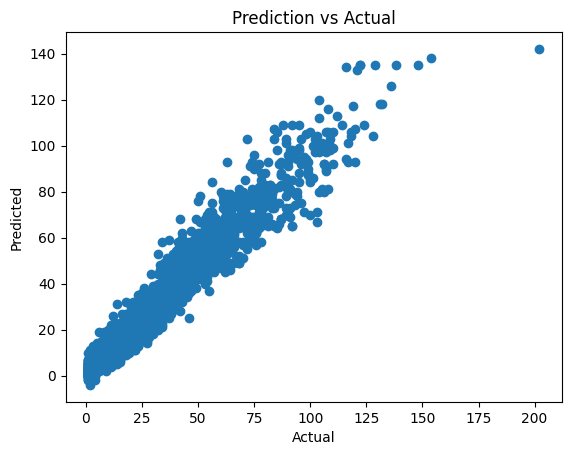

In [68]:
# Plotting the actual values
plt.scatter(y_test, predictions)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Prediction vs Actual')

# Displaying the plot
plt.show()


In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)


MSE: 44.165299402011726
RMSE: 6.645697811517744
MAE: 4.619051729848967
R-squared: 0.9433988701691974


In [70]:
rmse=np.sqrt(-scores)

In [71]:
print('rmse', np.round(rmse,2))
print('rmse mean: %0.22f' % (rmse.mean()))

rmse [2.66 2.11 2.42 2.47 2.13 2.18 2.08 2.14 2.4  3.58]
rmse mean: 2.4156566116049935644128
